In [36]:
import numpy as np
import pandas as pd

### Чтение файла 

In [54]:
# менять данную константу, если нужно сменить имя файла
FILE = 'done.xlsx'

In [55]:
data = pd.read_excel(FILE, index_col=0)

## 1) Фильтр отсутствия данных

In [81]:
#Константа для порогового значения, больше этого значения анкеты убираем
THRESHOLD1 = 0.25

Формируем набор $\phi_i $

In [83]:
logic_data = data.isnull()
ssv = logic_data.sum().sum() #сумма по всем v_ij
sv = logic_data.sum() #сумма по столбцам
#print(sv)
q_j = ssv/sv
sq_j = q_j[q_j != np.inf].sum() # стобцы со всеми заполненными строками не участвуют
#print(sq_j)

q_j[q_j == np.inf] = sq_j #костыли, чтоб бесконечности не было
Q_j = q_j / sq_j
#print(Q_j)
pheta_table = Q_j * logic_data
pheta_i = pheta_table.sum(axis=1)
pheta_i_sorted = pheta_i.sort_values(ascending=False)
FILTER1 = pheta_i_sorted[pheta_i_sorted>THRESHOLD1]
len(pheta_i_sorted[pheta_i_sorted>THRESHOLD1])

29

Визуализируем

Populating the interactive namespace from numpy and matplotlib


Отметка времени
2015-11-29 00:50:00.060    0.587225
2015-11-29 11:41:13.100    0.417564
2015-11-29 00:44:48.832    0.317458
2015-11-28 22:02:12.267    0.317458
2015-11-30 20:37:25.482    0.312668
2015-11-28 23:49:06.686    0.312668
2015-11-29 15:14:48.499    0.312668
2015-11-25 02:42:49.117    0.312668
2015-11-30 16:34:34.458    0.312668
2015-11-29 01:12:17.597    0.312668
2015-11-25 00:44:56.367    0.312668
2015-11-28 22:01:39.612    0.312668
2015-11-24 16:35:30.310    0.312668
2015-11-24 16:50:05.481    0.312668
2015-11-24 17:13:24.873    0.312668
2015-11-26 16:39:32.915    0.312668
2015-11-28 19:46:06.095    0.281056
2015-11-28 20:47:10.988    0.281056
2015-11-26 15:44:33.928    0.281056
2015-11-17 22:17:39.372    0.281056
2015-11-27 01:23:36.467    0.281056
2015-11-17 22:27:18.650    0.281056
2015-11-26 15:07:35.755    0.281056
2015-11-18 01:13:20.611    0.281056
2015-11-17 22:37:04.847    0.281056
2015-11-17 22:30:43.561    0.281056
2015-11-29 14:25:17.144    0.281056
2015-11-28 2

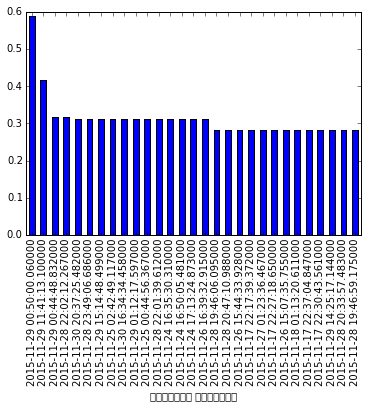

In [86]:
import matplotlib.pylab as pl
%pylab inline
pheta_i_sorted[pheta_i_sorted>THRESHOLD1].plot(kind='bar')
pheta_i_sorted.head(50)

In [85]:
new_data1 = data.drop(FILTER1.index)

##  2) Фильтр отсутствия данных групповой

Этот блок можно использовать для создания массива индексов групп пакетов

In [63]:
Nr = 5 # Количество анкет в пакете

In [64]:
ss_pheta_i = pheta_i.sum().sum()
Nr_counter = 0
N0 = len(data.index)
#делаем массив пакетов (начало, конец)
groups = []
one = []
####################################
# Делаем группы пакетов ############
def make_groups(Nr):
    groups = []
    one = []
    for row_n in range(N0):
        if (len(one) == Nr):
            groups.append(one)
            one = []
        one.append(data.index[row_n])
    else:
        if len(one)>0:
            groups.append(one) 
    return groups
####################################

Конец блока

In [65]:
Vr = []
groups = make_groups(Nr)
for group in groups:
    pheta_group = pheta_i[group]
    Wr = pheta_group.sum() / len(group)
    W_r = (ss_pheta_i -  pheta_group.sum()) / (N0 - len(group))
    Vr.append(W_r - Wr)

Визуализируем

,0
19,-0.169785
11,-0.133454
23,-0.111607
24,-0.111607
2,-0.091856


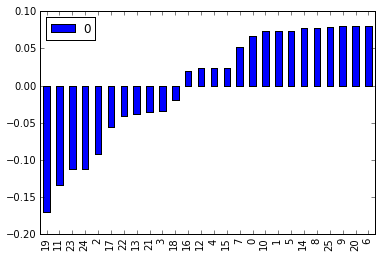

In [66]:
Vr_p = pd.DataFrame(Vr)
Vr_p = Vr_p.sort_values(by=0)
Vr_p.plot(kind='bar')
Vr_p.head()

In [80]:
#THRESHOLD2 = -0.1
#FILTER2 = Vr_p[Vr_p < THRESHOLD2]
#new_data2 = data.drop(FILTER2.index)

## 3) Фильтр экстремальных непрерывных значений

In [68]:
#data = 

In [69]:
X_minus_r = []
X_r = []
groups = make_groups(Nr)
for group in groups:
    data_group = data.loc[group]
    X_r.append(data_group.mean())
    data_group_out = data.loc[(data.index < group[0]) | (data.index > group[-1])]
    X_minus_r.append(data_group_out.mean())
    
lambd = []
for i in range(len(X_r)):
    lambd.append(X_minus_r[i] - X_r[i])
    
la = pd.DataFrame(lambd)
logic = la == la.max()
Mu_i = logic.sum(axis=1)

In [70]:
THRESHOLD3 = 0.9

Визуализируем

0     6
12    5
21    3
19    3
18    3
dtype: int64

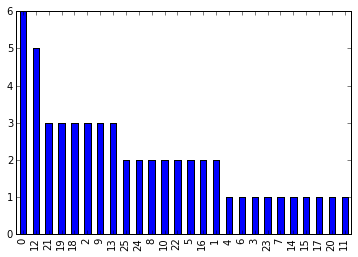

In [79]:
#Mu_p = pd.DataFrame(Mu_i)
Mu_sorted = Mu_i.sort_values(ascending=False)
Mu_sorted.plot(kind='bar')
#Mu_p[Mu_p>THRESHOLD]
Mu_sorted.head()

In [72]:
BAD_PACK = 0
FILTER3 = groups[BAD_PACK]
new_data3 = data.drop(FILTER3)

## 4) Фильтр ранжирования непрерывных значений

In [73]:
X_minus_r = []
X_r = []
groups = make_groups(Nr)
for group in groups:
    data_group = data.loc[group]
    X_r.append(data_group.mean())
    data_group_out = data.loc[(data.index < group[0]) | (data.index > group[-1])]
    X_minus_r.append(data_group_out.mean())
    
lambd = []
for i in range(len(X_r)):
    lambd.append(X_minus_r[i] - X_r[i])
    
la = pd.DataFrame(lambd)
M_4 = la.rank()

0     6
12    5
21    3
19    3
18    3
dtype: int64

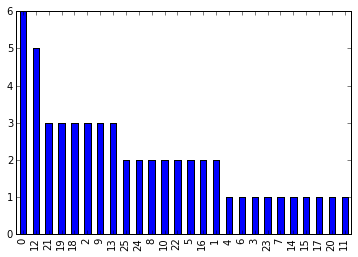

In [74]:
M_4_sorted = Mu_i.sort_values(ascending=False)
M_4_sorted.plot(kind='bar')
M_4_sorted.head()

In [75]:
BAD_PACK = 0
FILTER4 = groups[BAD_PACK]
new_data4 = data.drop(FILTER4)

## 5) Фильтр метрический непрерывных значений

## 6) Фильтр частот кодирования

## 7) Фильтр замены кодированных значений

In [76]:
A = data.copy()
for col in A:
    val_c = dict(A[col].value_counts())
    A[col] = A[col].map(val_c)
A_norm = A/len(A.index)
A_i = sum(A_norm, axis=1)

Визуализируем

In [77]:
THRESHOLD = 0.2

Отметка времени
2015-11-17 22:55:49.975    9.515873
2015-11-24 20:37:28.534    9.269841
2015-11-18 06:44:33.302    9.253968
2015-11-28 23:15:00.021    8.992063
2015-11-28 19:39:36.486    8.976190
2015-11-24 17:28:17.460    8.968254
2015-11-17 23:49:52.622    8.896825
2015-11-24 19:17:03.162    8.888889
2015-11-18 01:26:02.090    8.833333
2015-11-25 07:52:29.449    8.825397
2015-11-24 17:24:57.791    8.793651
2015-11-24 20:13:29.265    8.793651
2015-11-29 00:32:00.909    8.769841
2015-11-28 20:43:49.517    8.769841
2015-11-28 19:10:00.098    8.769841
2015-11-17 22:30:34.093    8.738095
2015-11-29 00:02:06.946    8.698413
2015-11-24 18:53:44.733    8.634921
2015-11-29 12:37:35.778    8.603175
2015-11-29 12:08:48.359    8.571429
2015-11-28 19:54:56.925    8.571429
2015-11-26 07:19:37.408    8.539683
2015-11-24 22:00:41.550    8.523810
2015-11-28 20:01:38.525    8.523810
2015-11-28 19:09:27.330    8.515873
2015-11-28 19:41:38.325    8.507937
2015-11-24 15:58:21.290    8.476190
2015-11-29 0

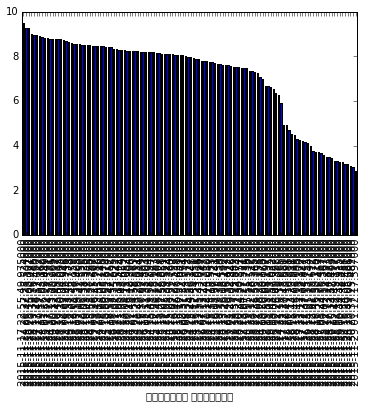

In [78]:
A_i = A_i.sort_values(ascending=False)
A_i[A_i>THRESHOLD].plot(kind='bar')
A_i[A_i>THRESHOLD]

In [590]:
FILTER7 = A_i[A_i > THRESHOLD2]
new_data7 = data.drop(FILTER7.index)